<a href="https://colab.research.google.com/github/JonathanRibeiro92/ReconhecimentoPadroes/blob/main/tarefa_heuristica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregamento Dataset Iris

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target

# Implementação Professor

In [21]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import numpy as np

def maisFrequente(y):
  return Counter(y.flat).most_common(1)[0][0]

def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i,k in enumerate(labels):
    probabilidades[i] = sum(y==k)/len(y)
  result = 1 - sum(probabilidades**2)
  return result

def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezaMaiores = impureza(y[maiores])
  propMaiores = sum(maiores)/len(y)
  impurezaMenores = impureza(y[~maiores])
  propMenores = sum(~maiores)/len(y)
  impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
  return impurezaTotal, impurezaMaiores, impurezaMenores

def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmin+xmax)/2
    impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
    if impTotal < menorImpureza:
      menorImpureza = impTotal
      result = valor
      if impMaiores == 0 or impMenores == 0:
        break
      if impMaiores < impMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break
  return result, menorImpureza

def melhorCaracteristica(X, y):
  impurezas = []
  valores = []
  for caracteristica in range(X.shape[1]):
    valor, imp = melhorValor(X[:,caracteristica], y)
    impurezas.append(imp)
    valores.append(valor)
  impurezas = np.array(impurezas)
  caracteristica = np.argmin(impurezas)
  return caracteristica, valores[caracteristica], impurezas[caracteristica]

class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)

  def predict(self, X):
    y = np.empty((X.shape[0]))
    if hasattr(self, "resposta"):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

#Minha Implementação

In [22]:
import random
seed = 42
random.seed(seed)

def melhorCaracteristicaJ(x):
  caracteristica = random.randint(0, x.shape[1] - 1)
  x_min = np.min(x[:, caracteristica])
  x_max = np.max(x[:, caracteristica])
  valor = (random.random() * (x_max - x_min)**2 + x_min)/ (x.shape[1] - 1)
  return caracteristica, valor

class ArvoreJ(BaseEstimator, ClassifierMixin):
  def fit(self, x, y):
    self.caracteristica, self.valor = melhorCaracteristicaJ(x)
    maiores = X[:,self.caracteristica] > self.valor
    if sum(maiores)>0 and sum(~maiores)>0:
      self.maiores = Arvore()
      self.maiores.fit(X[maiores,:], y[maiores])
      self.menores = Arvore()
      self.menores.fit(X[~maiores,:], y[~maiores])
    else:
      self.resposta = maisFrequente(y)
  
  def predict(self, X):
    y = np.empty((X.shape[0]))
    if hasattr(self, "resposta"):
      y[:] = self.resposta
    else:
      maiores = X[:,self.caracteristica] > self.valor
      y[maiores] = self.maiores.predict(X[maiores,:])
      y[~maiores] = self.menores.predict(X[~maiores,:])
    return y

# Função para plotar regição de Decisão

In [23]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

#Comparação das Regiões de Decisão

##Implementação do Professor

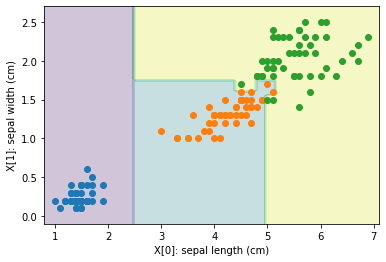

In [24]:
modeloProfessor = Arvore()
plotDecisao(modeloProfessor, X, y)

##Minha Implementação

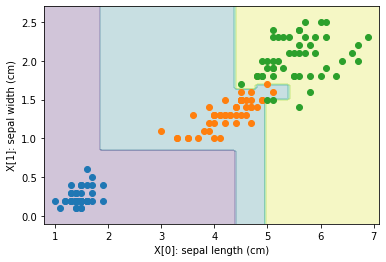

In [25]:
meuModelo = ArvoreJ()
plotDecisao(meuModelo, X, y)

##Implementação ScikitLearn

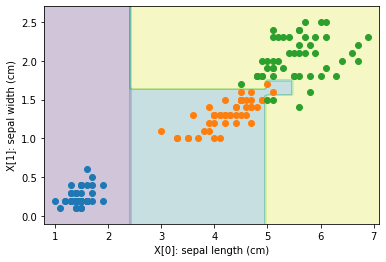

In [26]:
from sklearn.tree import DecisionTreeClassifier
modeloArvoreSklearn = DecisionTreeClassifier(random_state=seed)
plotDecisao(modeloArvoreSklearn, X, y)

##Comparações de Resultados

In [35]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def comparar(X, y):
  ypred = modeloProfessor.predict(X)
  cross_val = cross_val_score(modeloProfessor, X, y)
  acuracia = accuracy_score(y, ypred)
  print(f'Modelo Professor:  Acurácia:{acuracia}, CrossValidate:{cross_val}')

  meuModelo.fit(X,y)
  ypred = meuModelo.predict(X)
  cross_val = cross_val_score(meuModelo, X, y)
  acuracia = accuracy_score(y, ypred)
  print(f'Meu modelo:  Acurácia:{acuracia}, CrossValidate:{cross_val}')


  ypred = modeloArvoreSklearn.predict(X)
  cross_val = cross_val_score(modeloArvoreSklearn, X, y)
  acuracia = accuracy_score(y, ypred)
  print(f'Modelo Sklearn:  Acurácia:{acuracia}, CrossValidate:{cross_val}')

  ypred = modeloArvoreSklearn.predict(X)
  cross_val = cross_val_score(DummyClassifier(), X, y)
  acuracia = accuracy_score(y, ypred)
  print(f'Modelo Sklearn:  Acurácia:{acuracia}, CrossValidate:{cross_val}')

  zeroR=DummyClassifier(strategy="most_frequent")
  zeroR.fit(X,y)
  ypred = zeroR.predict(X)
  cross_val = cross_val_score(zeroR, X, y)
  acuracia = accuracy_score(y, ypred)
  print(f'Modelo Professor:  Acurácia:{acuracia}, CrossValidate:{cross_val}')

comparar(X, y)

Modelo Professor:  Acurácia:0.9933333333333333, CrossValidate:[0.96666667 0.96666667 0.9        0.93333333 1.        ]
Meu modelo:  Acurácia:0.3333333333333333, CrossValidate:[0.33333333        nan 0.33333333        nan        nan]
Modelo Sklearn:  Acurácia:0.9933333333333333, CrossValidate:[0.96666667 0.96666667 0.9        0.96666667 1.        ]
Modelo Sklearn:  Acurácia:0.9933333333333333, CrossValidate:[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
Modelo Professor:  Acurácia:0.3333333333333333, CrossValidate:[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-22-778c47222e63>", line 18, in fit
    self.maiores.fit(X[maiores,:], y[maiores])
IndexError: boolean index did not match indexed array along dimension 0; dimension is 120 but corresponding boolean dimension is 150

  warnings.warn(some_fits_failed_message, FitFailedWarning)
